In [44]:
# pip install simplekml

     ---------------------------------------- 0.0/53.0 kB ? eta -:--:--
     ------- -------------------------------- 10.2/53.0 kB ? eta -:--:--
     ------- -------------------------------- 10.2/53.0 kB ? eta -:--:--
     ------- -------------------------------- 10.2/53.0 kB ? eta -:--:--
     -------------- ----------------------- 20.5/53.0 kB 131.3 kB/s eta 0:00:01
     ---------------------- --------------- 30.7/53.0 kB 163.8 kB/s eta 0:00:01
     ----------------------------- -------- 41.0/53.0 kB 178.6 kB/s eta 0:00:01
     -------------------------------------- 53.0/53.0 kB 210.6 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for simplekml: filename=simplekml-1.3.6-py3-none-any.whl size=65874 sha256=ba685b5ca68bbb7feab8aa80f5157d7f684e51882989ce24e8aeee9ec887ac67
  Stored in directory: c:\snapvolumestemp\mountpoints\{45c63495-0000-0000-0000-100000000000}\{7aee604f-734a-4a8e-b9e8-92284c5cc920}

DEPRECATION: mapbox 0.16.1 has a non-standard dependency specifier python-dateutil>=2.5.0requests. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of mapbox or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: nb-black 1.0.7 has a non-standard dependency specifier black>='19.3'; python_version >= "3.6". pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of nb-black or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
from scipy.spatial import KDTree
import numpy as np

# Additional imports
import pystac_client
import xarray as xr
import pathlib
import os
import geopandas as gpd
import matplotlib as mpl
from matplotlib import colors
import rasterio

import cartopy.crs as ccrs
import cartopy
import plotly.graph_objects as go
import plotly.express as px
from rasterio.plot import show

import matplotlib.colors as mcolors
from shapely.geometry import Point
import pandas as pd

from tqdm import tqdm

import webbrowser
from pathlib import Path
import os
import time

from itertools import compress
import pandas as pd

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

from tqdm import tqdm

from shapely.geometry import box



Read different points for experts

In [39]:
df=pd.read_csv(r"C:\Users\rowe\Documents\GitHub\global-coastal-atlas\STAC\visualization\SOTC_transect_mapping_visual\Finalized ML Database2.csv")
circle_center = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.x, df.y), crs="EPSG:4326"
)
circle_center

,fid,Number,Sandy Beach Name,Country,x,y,geometry
0,1,Sandy,Copacabana Beach,Brazil,-43.184285,-22.973883,POINT (-43.18428 -22.97388)
1,2,Sandy,Bondi Beach,Australia,151.276534,-33.892192,POINT (151.27653 -33.89219)
2,3,Sandy,Waikiki Beach,United States,-157.836584,21.280074,POINT (-157.83658 21.28007)
3,4,Sandy,Santander,Spain,-3.505031,43.474032,POINT (-3.50503 43.47403)
4,5,Sandy,Accra,Ghana,0.023618,5.644583,POINT (0.02362 5.64458)
...,...,...,...,...,...,...,...
145,146,Silty,Tugela River Estuary,South Africa,31.506790,-29.221943,POINT (31.50679 -29.22194)
146,147,Silty,Seine Estuary,France,0.084694,49.501710,POINT (0.08469 49.50171)
147,148,Silty,Dee Estuary,Wales,-3.322297,53.356403,POINT (-3.32230 53.35640)
148,149,Silty,Cook Inlet,USA,-149.971701,61.120370,POINT (-149.97170 61.12037)


In [40]:
import utm
def degrees_to_m(lat1, lon1,lat2, lon2):
    # Calculate UTM zone for the given latitude and longitude
    utm_zone = utm.from_latlon(lat1, lon1)[2]

    # Get UTM projection parameters
    utm_params1 = utm.from_latlon(lat1, lon1)
    utm_params2 = utm.from_latlon(lat2, lon2)

    dist_lat= abs(utm_params1[0]-utm_params2[0])
    dist_lon= abs(utm_params1[1]-utm_params2[1])

    pixel_dist_m=dist_lat

    return  pixel_dist_m


lon1=circle_center["x"][0]
lat1=circle_center["y"][0]
lon2=lon1+0.0001
lat2=lat1+0.0001


dist_m = degrees_to_m(lat1, lon1,lat2, lon2)
print("Pixel dist in meters:", dist_m)

dist_lat_deg=abs(lat1-lat2)
print("1000m equivalent in degrees:", (dist_lat_deg/dist_m)*1000)

Pixel dist in meters: 10.390754214837216
1000m equivalent in degrees: 0.009623940469785578


In [37]:
circle_center["geometry"].x

0      -43.184285
1      151.276534
2     -157.836584
3       -3.505031
4        0.023618
          ...    
145     31.506790
146      0.084694
147     -3.322297
148   -149.971701
149     -8.535598
Length: 150, dtype: float64

In [41]:
check_distance_m=1000#1000m buffer radius
check_distances=[]
# buffer_circles = gpd.GeoDataFrame([Polygon(p.buffer(check_distance)) for p in circle_center[0][:5]])
for beach in circle_center['geometry']:
    
    lon1=beach.x
    lat1=beach.y
    lon2=lon1+0.001
    lat2=lat1+0.001 #~10m to ensure same utm zone

    dist_m = degrees_to_m(lat1, lon1,lat2, lon2)
    dist_lat_deg=abs(lat1-lat2) 
    check_distance=(dist_lat_deg/dist_m)*check_distance_m
    check_distances.append(check_distance)

buffer_circles = gpd.GeoDataFrame({'geometry':  [Polygon(beach.buffer(check_distances[i])) for i,beach in enumerate(circle_center['geometry'])]})

buffer_circles

,geometry
0,"POLYGON ((-43.17466 -22.97388, -43.17471 -22.9..."
1,"POLYGON ((151.28757 -33.89219, 151.28752 -33.8..."
2,"POLYGON ((-157.82687 21.28007, -157.82692 21.2..."
3,"POLYGON ((-3.49277 43.47403, -3.49283 43.47283..."
4,"POLYGON ((0.03259 5.64458, 0.03255 5.64370, 0...."
...,...
145,"POLYGON ((31.51723 -29.22194, 31.51718 -29.222..."
146,"POLYGON ((0.09773 49.50171, 0.09767 49.50043, ..."
147,"POLYGON ((-3.30738 53.35640, -3.30746 53.35494..."
148,"POLYGON ((-149.95472 61.12037, -149.95480 61.1..."


In [19]:
buffer_circles["geometry"][1:5]

1    POLYGON ((151.28574 -33.89150, 151.28568 -33.8...
2    POLYGON ((-157.84599 21.27510, -157.84603 21.2...
3    POLYGON ((-151.74069 -16.50000, -151.74074 -16...
4    POLYGON ((55.90563 -4.46080, 55.90558 -4.46168...
Name: geometry, dtype: geometry

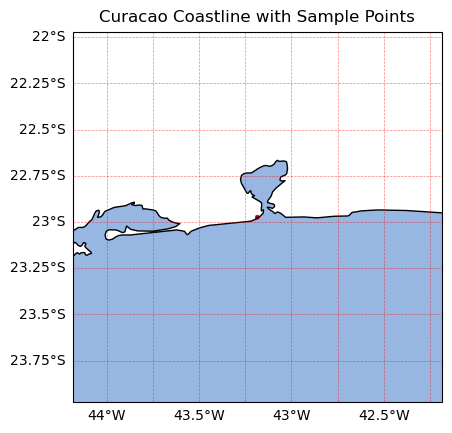

In [42]:
import matplotlib.pyplot as plt

# Plot the buffer circles
ax = plt.axes(projection=ccrs.PlateCarree())
buffer_circles.plot(ax=ax,edgecolor='red', facecolor='blue', figsize=(10, 8))

# Add features like coastlines, borders, and ocean
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, linestyle=':', edgecolor='black')
ax.add_feature(cartopy.feature.OCEAN)

# circle_center.plot(ax=ax, color='blue', markersize=5)
ax.set_title('Curacao Coastline with Sample Points')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_aspect('equal')
buffer_center = buffer_circles["geometry"].iloc[0].centroid
plt.xlim(buffer_center.x - 1, buffer_center.x + 1)
plt.ylim(buffer_center.y - 1, buffer_center.y + 1)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='red', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

plt.show()

In [47]:
circle_center.head()

,fid,Number,Sandy Beach Name,Country,x,y,geometry
0,1,Sandy,Copacabana Beach,Brazil,-43.184285,-22.973883,POINT (-43.18428 -22.97388)
1,2,Sandy,Bondi Beach,Australia,151.276534,-33.892192,POINT (151.27653 -33.89219)
2,3,Sandy,Waikiki Beach,United States,-157.836584,21.280074,POINT (-157.83658 21.28007)
3,4,Sandy,Santander,Spain,-3.505031,43.474032,POINT (-3.50503 43.47403)
4,5,Sandy,Accra,Ghana,0.023618,5.644583,POINT (0.02362 5.64458)


In [49]:
import simplekml


# Create a KML object
kml = simplekml.Kml()

# Iterate over each buffer circle and add it to the KML object
for index, row in buffer_circles.iterrows():
    coords = list(row['geometry'].exterior.coords)
    pol = kml.newpolygon(name=circle_center["Sandy Beach Name"][index] +", "+ circle_center["Country"][index], outerboundaryis=coords)
    pol.style.linestyle.color = simplekml.Color.red  # Set the outline color of the circle
    pol.style.linestyle.width = 2  # Set the width of the outline

    # Set fill color with 50% opacity (Alpha value of 128)
    fill_color = simplekml.Color.changealphaint(128, simplekml.Color.white)
    pol.style.polystyle.color = fill_color

# Specify the output file path
output_kmz_file = "Beach asessment location for experts.kmz"

# Save the KML object to a KMZ file
kml.savekmz(output_kmz_file)

print(f"Buffer circles exported to {output_kmz_file}")

Buffer circles exported to Beach asessment location for experts.kmz


In [46]:
index

149